# Цель

С приложенным сэмплом нужно сделать следующее:

-сделать модель, предсказывающую вероятность дефолта (таргет fpd5_flg), в качестве предикторов можно использовать все что есть в файле (не обязательно абсолютно все), кроме dt (это дата выдачи кредита). Можно делать в чем угодно. Преобразовывать переменные можно как угодно. В качестве инструмента можно выбрать обычную логистическую регрессию.

-на выходе должен быть тот же самый файл, но напротив каждого наблюдения должна быть проставлена вероятность дефолта по построенной модели

-нужно сделать мини-отчет по модели в Excel или Word (или Jupiter Notebook), показать Gini (AuROC) модели, распределение (гистограмму) по предсказанной вероятности дефолта и описать кратко что было сделано и как

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, roc_auc_score, roc_curve, confusion_matrix)
import seaborn as sns
from sklearn import metrics

In [2]:
data = pd.read_excel("Test Sample.xlsx")

In [3]:
data.dtypes

fpd5_flg                    int64
dt                         object
gender                      int64
device_quaility_index     float64
behavioral_index          float64
type_of_document           object
age                         int64
email_domain_formatted     object
social_status              object
salary                    float64
disbursment_type           object
os                         object
email_index               float64
dtype: object

In [4]:
data.head(5)

,fpd5_flg,dt,gender,device_quaility_index,behavioral_index,type_of_document,age,email_domain_formatted,social_status,salary,disbursment_type,os,email_index
0,0,2021-01-22,0,NaN,NaN,UMID,26,GMAIL.COM,Private Company Employee,20000.0,Bank,Android,0.0
1,0,2020-12-14,1,3.0,4.0,UMID,32,GMAIL.COM,Other,18000.0,E-wallet,Android,1.0
2,1,2021-01-26,0,0.0,3.0,SSS,41,YAHOO.COM,Private Company Employee,14000.0,Bank,Android,1.0
3,1,2020-12-10,1,0.0,5.0,TIN,28,GMAIL.COM,BPO Professionals,40000.0,E-wallet,Android,1.0
4,1,2021-01-17,0,3.0,3.0,UMID,31,GMAIL.COM,BPO Professionals,25000.0,Bank,Android,0.0


In [5]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [6]:
data.describe()

,fpd5_flg,gender,device_quaility_index,behavioral_index,age,salary,email_index
count,15363.000,15363.000,14798.000,14798.000,15363.000,14649.000,15330.000
mean,0.273,0.629,2.370,4.051,35.136,126164.737,1.580
std,0.445,0.483,1.078,0.938,9.125,12393318.436,2.398
min,0.000,0.000,0.000,1.000,21.000,0.000,0.000
25%,0.000,0.000,2.000,3.000,28.000,15000.000,0.000
50%,0.000,1.000,3.000,4.000,34.000,20000.000,1.000
75%,1.000,1.000,3.000,5.000,41.000,26000.000,1.000
max,1.000,1.000,4.000,6.000,69.000,1500020000.000,12.000


In [7]:
# В переменной Salary есть выбросы!

In [8]:
median_salary = data['salary'].median()
data[data['salary'] >= median_salary * 30]

,fpd5_flg,dt,gender,device_quaility_index,behavioral_index,type_of_document,age,email_domain_formatted,social_status,salary,disbursment_type,os,email_index
1540,0,2020-12-21,1,1.000,5.000,SSS,41,GMAIL.COM,Business Owner,1500020000.000,Bank,Android,1.000
5082,0,2020-12-16,0,1.000,4.000,SSS,49,GMAIL.COM,Self-Employed,900000.000,Bank,Android,1.000
6826,0,2020-12-21,0,4.000,4.000,Passport,25,GMAIL.COM,Business Owner,800000.000,Bank,iOS,0.000
8811,0,2021-01-28,1,1.000,3.000,SSS,42,GMAIL.COM,Government Employee,2387700.000,E-wallet,Android,8.000
13821,0,2020-12-22,1,3.000,5.000,SSS,40,GMAIL.COM,"Professional Worker (Doctors, Engineers, Accou...",780000.000,Bank,iOS,1.000


In [9]:
# размерность исходной выборки
data.shape

(15363, 13)

In [10]:
#data = data[data['salary'] != 1500020000]
#data = data[data['salary'] != 2387700]

In [11]:
data.describe()

,fpd5_flg,gender,device_quaility_index,behavioral_index,age,salary,email_index
count,15363.000,15363.000,14798.000,14798.000,15363.000,14649.000,15330.000
mean,0.273,0.629,2.370,4.051,35.136,126164.737,1.580
std,0.445,0.483,1.078,0.938,9.125,12393318.436,2.398
min,0.000,0.000,0.000,1.000,21.000,0.000,0.000
25%,0.000,0.000,2.000,3.000,28.000,15000.000,0.000
50%,0.000,1.000,3.000,4.000,34.000,20000.000,1.000
75%,1.000,1.000,3.000,5.000,41.000,26000.000,1.000
max,1.000,1.000,4.000,6.000,69.000,1500020000.000,12.000


In [12]:
data.groupby('fpd5_flg').mean()

,gender,device_quaility_index,behavioral_index,age,salary,email_index
fpd5_flg,,,,,,
0,0.647,2.412,4.031,35.456,165375.890,1.517
1,0.582,2.258,4.107,34.282,21523.102,1.747


# Этап валидации входящих данных

In [13]:
data.shape

(15363, 13)

In [14]:
# Количетсво пропусков в данных
data.isna().sum()

fpd5_flg                    0
dt                          0
gender                      0
device_quaility_index     565
behavioral_index          565
type_of_document            0
age                         0
email_domain_formatted      0
social_status               0
salary                    714
disbursment_type            0
os                         16
email_index                33
dtype: int64

In [15]:
share_missing = round(data.isna().sum()/data.count(), 3)
print('Доля пропущенных переменных')
share_missing

Доля пропущенных переменных


fpd5_flg                 0.000
dt                       0.000
gender                   0.000
device_quaility_index    0.038
behavioral_index         0.038
type_of_document         0.000
age                      0.000
email_domain_formatted   0.000
social_status            0.000
salary                   0.049
disbursment_type         0.000
os                       0.001
email_index              0.002
dtype: float64

In [16]:
# Уникальные значения
data.columns

Index(['fpd5_flg', 'dt', 'gender', 'device_quaility_index', 'behavioral_index',
       'type_of_document', 'age', 'email_domain_formatted', 'social_status',
       'salary', 'disbursment_type', 'os', 'email_index'],
      dtype='object')

In [17]:
unique_col = ['fpd5_flg', 'gender', 'device_quaility_index', 'behavioral_index',
       'type_of_document', 'age', 'email_domain_formatted', 'social_status', 'disbursment_type', 'os', 'email_index']

In [18]:
# Удаляем пропуски
data_not_nan = data.dropna()

In [19]:
data_not_nan.shape

(14073, 13)

In [20]:
for v in unique_col:
    print(v)
    print(np.unique(data_not_nan[v]))

fpd5_flg
[0 1]
gender
[0 1]
device_quaility_index
[0. 1. 2. 3. 4.]
behavioral_index
[1. 2. 3. 4. 5. 6.]
type_of_document
['Driver license ID' 'PRC' 'Passport' 'SSS' 'TIN' 'UMID']
age
[21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44
 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68
 69]
email_domain_formatted
['75GMAIL.COM' 'ABS-CBN.COM' 'ABSOLUTELYCANDO.COM' 'AMA.EDU.PH'
 'AMSAMOA.EDU' 'ATENEO.EDU' 'BEROVAN.COM' 'BOLTONINTERNATIONAL.COM'
 'BULSU.EDU.PH' 'BURGANDRILLING.COM' 'CAREMIN.COM' 'CIENCE.COM' 'CIIF.PH'
 'CPSCTECH.ORG' 'DAVIESPAINTS.COM.PH' 'DENR.GOV.PH' 'DEPED.GOV.PH'
 'DEPEDQC.PH' 'DEXCOM.COM' 'DLSL.EDU.PH' 'DLSU.EDU.PH' 'EMAIL.COM'
 'EMAIL.COM.PH' 'EMAIL.PH' 'FRONTIER.COM' 'GLOBE.COM.PH'
 'GLOBEPARTNERS.COM.PH' 'GMA.COM' 'GMAIL.COM' 'GOOGLE.COM.COM'
 'GSIS.GOV.PH' 'GXII.COM.PH' 'HARADA.COM.PH' 'HELLOKITTY.COM'
 'HOTMAIL.COM' 'HOTMAIL.PH' 'ICBBPRESCHOOL.COM' 'ICLOUD.COM' 'INFOR.COM'
 'INNOVARETEKHNE.COM' 'IRVILENT.COM' 'JFC.COM.PH

In [21]:
data.columns

Index(['fpd5_flg', 'dt', 'gender', 'device_quaility_index', 'behavioral_index',
       'type_of_document', 'age', 'email_domain_formatted', 'social_status',
       'salary', 'disbursment_type', 'os', 'email_index'],
      dtype='object')

# Графики

In [22]:
def plt_dist(value_to_plot):
    plt.hist(data[value_to_plot])
    plt.title(value_to_plot)
    plt.ylabel('Frequency')
    plt.show()

In [23]:
def sns_dist(value_to_plot):
    sns.countplot(x = value_to_plot, data = data, palette = 'hls').set(title=value_to_plot)
    plt.show()

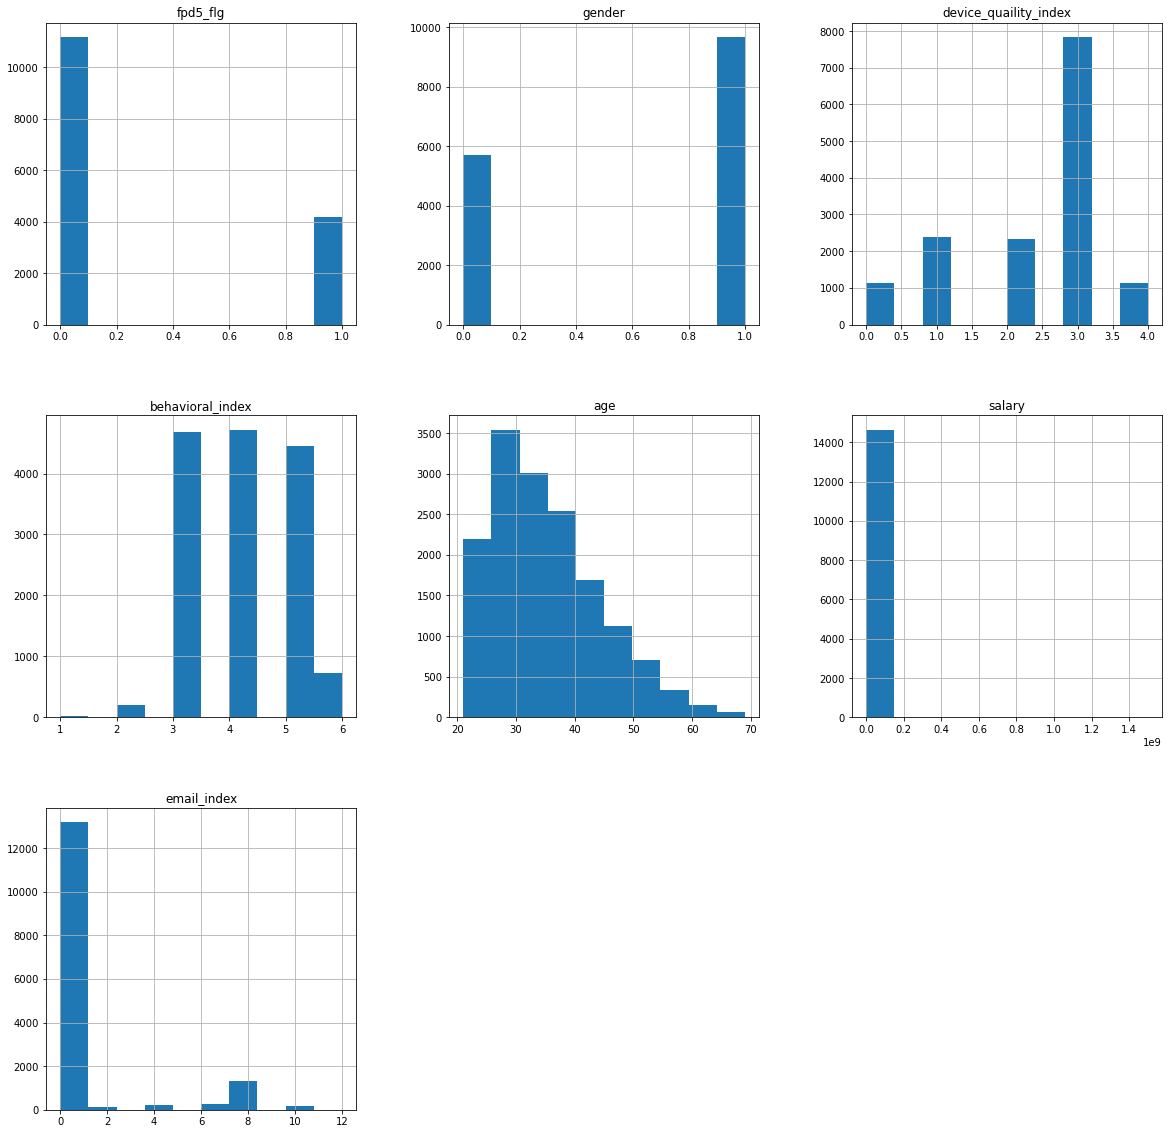

In [24]:
# Визуализируем данные - все сразу
data.hist(figsize = (20, 20));

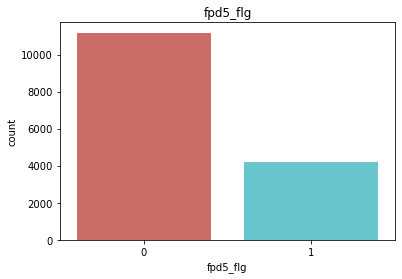

In [25]:
sns_dist('fpd5_flg')

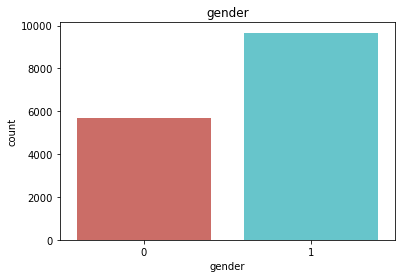

In [26]:
sns_dist('gender')

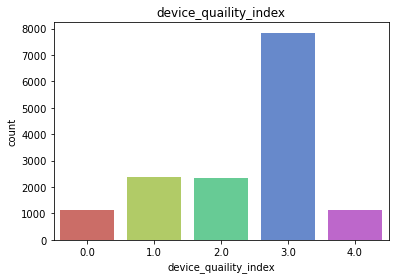

In [27]:
sns_dist('device_quaility_index')

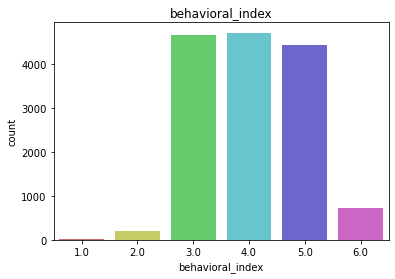

In [28]:
sns_dist('behavioral_index')

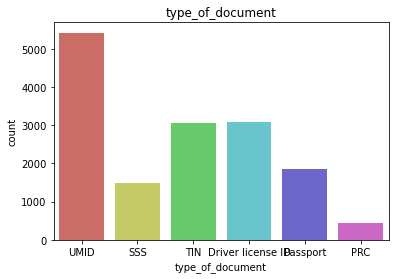

In [29]:
sns_dist('type_of_document')

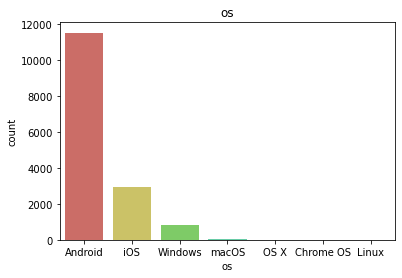

In [30]:
sns_dist('os')

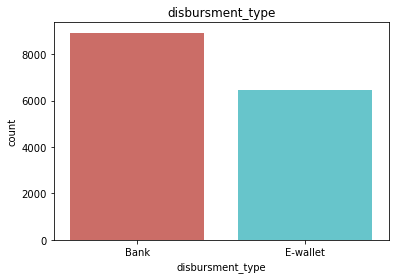

In [31]:
sns_dist('disbursment_type')

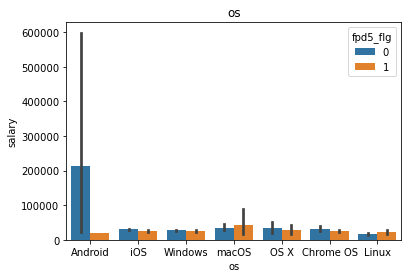

In [32]:
sns.barplot(x = 'os',  y ='salary', hue = 'fpd5_flg', data = data).set(title='os')
plt.show()

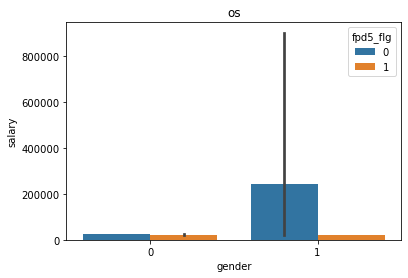

In [33]:
sns.barplot(x = 'gender',  y ='salary', hue = 'fpd5_flg', data = data).set(title='os')
plt.show()

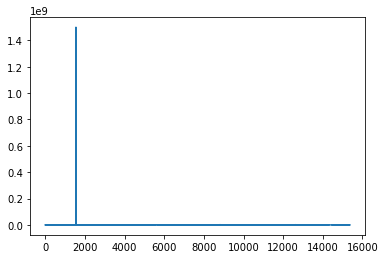

In [34]:
plt.plot(data['salary'])

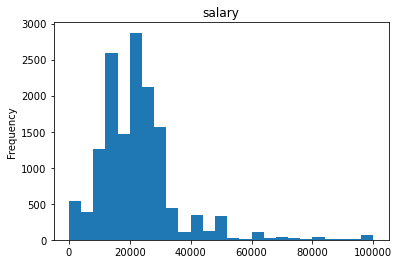

In [35]:
plt.hist(data['salary'], bins = 25, range = (0, data['salary'].median() * 5))
plt.title('salary')
plt.ylabel('Frequency')
plt.show()

In [36]:
value_list = ['fpd5_flg', 'gender', 'device_quaility_index', 'behavioral_index',
       'type_of_document', 'age', 'email_domain_formatted', 'social_status',
       'salary', 'disbursment_type', 'os', 'email_index']

# Распределение по кол-ву

In [37]:
def dist_value_cnt(value):
    x = data.groupby(value)[value].count().reset_index(name='counts').sort_values('counts', ascending = False)
    return x

In [38]:
dist_value_cnt('fpd5_flg')

,fpd5_flg,counts
0,0,11172
1,1,4191


In [39]:
dist_value_cnt('gender')

,gender,counts
1,1,9665
0,0,5698


In [40]:
dist_value_cnt('device_quaility_index')

,device_quaility_index,counts
3,3.000,7837
1,1.000,2374
2,2.000,2337
4,4.000,1128
0,0.000,1122


In [41]:
dist_value_cnt('behavioral_index')

,behavioral_index,counts
3,4.000,4721
2,3.000,4675
4,5.000,4447
5,6.000,730
1,2.000,202
0,1.000,23


In [42]:
dist_value_cnt('type_of_document')

,type_of_document,counts
5,UMID,5419
0,Driver license ID,3073
4,TIN,3057
2,Passport,1867
3,SSS,1498
1,PRC,449


In [43]:
dist_value_cnt('social_status')

,social_status,counts
6,Private Company Employee,3500
10,Self-Employed,2323
0,BPO Professionals,2295
5,Other,1703
1,Business Owner,1680
4,Government Employee,1061
3,Freelance,777
7,"Professional Worker (Doctors, Engineers, Accou...",642
11,Unemployed,642
8,Retail Worker,402


In [44]:
dist_value_cnt('disbursment_type')

,disbursment_type,counts
0,Bank,8918
1,E-wallet,6445


In [45]:
dist_value_cnt('os')

,os,counts
0,Android,11499
5,iOS,2947
4,Windows,845
6,macOS,40
2,Linux,7
1,Chrome OS,5
3,OS X,4


In [46]:
dist_value_cnt('email_index')

,email_index,counts
1,1.000,8926
0,0.000,4253
6,8.000,1329
5,6.000,273
4,4.000,232
7,10.000,176
2,2.000,129
3,3.000,7
9,12.000,4
8,11.000,1


In [47]:
data.groupby('dt')['dt'].count().reset_index(name='counts').sort_values('dt', ascending = True)

,dt,counts
0,2020-12-09,543
1,2020-12-10,297
2,2020-12-11,351
3,2020-12-12,151
4,2020-12-13,99
5,2020-12-14,510
6,2020-12-15,228
7,2020-12-16,206
8,2020-12-17,190
9,2020-12-18,154


# Создаем новые переменные по age и salary

In [48]:
data.describe()

,fpd5_flg,gender,device_quaility_index,behavioral_index,age,salary,email_index
count,15363.000,15363.000,14798.000,14798.000,15363.000,14649.000,15330.000
mean,0.273,0.629,2.370,4.051,35.136,126164.737,1.580
std,0.445,0.483,1.078,0.938,9.125,12393318.436,2.398
min,0.000,0.000,0.000,1.000,21.000,0.000,0.000
25%,0.000,0.000,2.000,3.000,28.000,15000.000,0.000
50%,0.000,1.000,3.000,4.000,34.000,20000.000,1.000
75%,1.000,1.000,3.000,5.000,41.000,26000.000,1.000
max,1.000,1.000,4.000,6.000,69.000,1500020000.000,12.000


In [49]:
data['salary_cat'] = 0
data['age_cat'] = 0

In [50]:
data['salary_cat'][(data['salary'] >= 0) & (data['salary'] < 15000)] = 1
data['salary_cat'][(data['salary'] >= 15000) & (data['salary'] < 20000)] = 2
data['salary_cat'][(data['salary'] >= 20000) & (data['salary'] < 26000)] = 3
data['salary_cat'][(data['salary'] >= 26000) & (data['salary'] < 400000)] = 5
data['salary_cat'][(data['salary'] >= 400000) | (data['salary'].isna())] = 4

C:\Users\75BD~1\AppData\Local\Temp/ipykernel_4904/1396096759.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['salary_cat'][(data['salary'] >= 0) & (data['salary'] < 15000)] = 1
C:\Users\75BD~1\AppData\Local\Temp/ipykernel_4904/1396096759.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['salary_cat'][(data['salary'] >= 15000) & (data['salary'] < 20000)] = 2
C:\Users\75BD~1\AppData\Local\Temp/ipykernel_4904/1396096759.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

In [51]:
data['age_cat'][(data['age'] >= 21) & (data['age'] < 28)] = 1
data['age_cat'][(data['age'] >= 28) & (data['age'] < 34)] = 2
data['age_cat'][(data['age'] >= 34) & (data['age'] < 41)] = 3
data['age_cat'][(data['age'] >= 41) & (data['age'] <= 69)] = 4
data['age_cat'][(data['age'] >= 70) | (data['age'].isna())] = 5

C:\Users\75BD~1\AppData\Local\Temp/ipykernel_4904/1334996085.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['age_cat'][(data['age'] >= 21) & (data['age'] < 28)] = 1
C:\Users\75BD~1\AppData\Local\Temp/ipykernel_4904/1334996085.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['age_cat'][(data['age'] >= 28) & (data['age'] < 34)] = 2
C:\Users\75BD~1\AppData\Local\Temp/ipykernel_4904/1334996085.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

In [52]:
data[data['age_cat'] == 5]

,fpd5_flg,dt,gender,device_quaility_index,behavioral_index,type_of_document,age,email_domain_formatted,social_status,salary,disbursment_type,os,email_index,salary_cat,age_cat


# WOE и IV

In [53]:
data.dtypes

fpd5_flg                    int64
dt                         object
gender                      int64
device_quaility_index     float64
behavioral_index          float64
type_of_document           object
age                         int64
email_domain_formatted     object
social_status              object
salary                    float64
disbursment_type           object
os                         object
email_index               float64
salary_cat                  int64
age_cat                     int64
dtype: object

In [54]:
data.head(2)

,fpd5_flg,dt,gender,device_quaility_index,behavioral_index,type_of_document,age,email_domain_formatted,social_status,salary,disbursment_type,os,email_index,salary_cat,age_cat
0,0,2021-01-22,0,NaN,NaN,UMID,26,GMAIL.COM,Private Company Employee,20000.000,Bank,Android,0.000,3,1
1,0,2020-12-14,1,3.000,4.000,UMID,32,GMAIL.COM,Other,18000.000,E-wallet,Android,1.000,2,2


In [55]:
# категориальные переменные:
# gender, device_quaility_index, behavioral_index, type_of_document, social_status, 'disbursment_type', 'os', 'email_index'

In [56]:
nominal_inputs = ['gender', 'device_quaility_index', 'behavioral_index', 'type_of_document', 'social_status',
                  'disbursment_type', 'os', 'email_index']
cont_inputs = ['age', 'salary']
target = 'target'

In [57]:
def WoE_categorial(data, categorial_value):
    WoE = pd.crosstab(data[categorial_value].fillna('missing'), data['fpd5_flg'])
    WoE.columns = ('Not-event', 'Event')
    WoE['% Not-event'] = round(WoE['Not-event']/WoE['Not-event'].sum(), 3)
    WoE['% Event'] = round(WoE['Event']/WoE_gender['Event'].sum(), 3)
    WoE['WoE'] = round(np.log(WoE['% Not-event']/WoE['% Event']), 3)
    WoE['IV'] = round((WoE['% Not-event'] - WoE['% Event']) * WoE['WoE'], 3)
    WoE['IV'] = WoE['IV'].replace([np.inf, -np.inf], 0) # Заменяем inf на 0
    WoE['share_bin'] = round((WoE['Not-event'] + WoE['Event']) / len(data), 3)
    return WoE.sort_values('WoE')

In [58]:
WoE_gender = pd.crosstab(data["gender"], data["fpd5_flg"])
WoE_gender.columns = ('Not-event', 'Event')
WoE_gender['% Not-event'] = WoE_gender['Not-event']/WoE_gender['Not-event'].sum()
WoE_gender['% Event'] = WoE_gender['Event']/WoE_gender['Event'].sum()
WoE_gender['WoE'] = np.log(WoE_gender['% Not-event']/WoE_gender['% Event'])
WoE_gender['IV'] = (WoE_gender['% Not-event'] - WoE_gender['% Event']) * WoE_gender['WoE']
WoE_gender

,Not-event,Event,% Not-event,% Event,WoE,IV
gender,,,,,,
0,3948,1750,0.353,0.418,-0.167,0.011
1,7224,2441,0.647,0.582,0.105,0.007


In [59]:
WoE_categorial(data, 'gender')

,Not-event,Event,% Not-event,% Event,WoE,IV,share_bin
gender,,,,,,,
0,3948,1750,0.353,0.418,-0.169,0.011,0.371
1,7224,2441,0.647,0.582,0.106,0.007,0.629


In [60]:
WoE_categorial(data, 'gender')['IV'].sum()

0.018

In [61]:
WoE_categorial(data, 'device_quaility_index')

,Not-event,Event,% Not-event,% Event,WoE,IV,share_bin
device_quaility_index,,,,,,,
0.0,751,371,0.067,0.089,-0.284,0.006,0.073
2.0,1618,719,0.145,0.172,-0.171,0.005,0.152
missing,399,166,0.036,0.040,-0.105,0.000,0.037
1.0,1683,691,0.151,0.165,-0.089,0.001,0.155
3.0,5819,2018,0.521,0.482,0.078,0.003,0.510
4.0,902,226,0.081,0.054,0.405,0.011,0.073


In [62]:
WoE_categorial(data, 'device_quaility_index')['IV'].sum()

0.026

In [63]:
data['device_cat'] = 0

data['device_cat'][(data['device_quaility_index'] == 0)] = 1
data['device_cat'][(data['device_quaility_index'] == 2) | (data['device_quaility_index'].isna())] = 2
data['device_cat'][(data['device_quaility_index'] == 1)] = 3
data['device_cat'][(data['device_quaility_index'] == 3)] = 4
data['device_cat'][(data['device_quaility_index'] == 4)] = 5

C:\Users\75BD~1\AppData\Local\Temp/ipykernel_4904/2369583151.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['device_cat'][(data['device_quaility_index'] == 0)] = 1
C:\Users\75BD~1\AppData\Local\Temp/ipykernel_4904/2369583151.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['device_cat'][(data['device_quaility_index'] == 2) | (data['device_quaility_index'].isna())] = 2
C:\Users\75BD~1\AppData\Local\Temp/ipykernel_4904/2369583151.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [64]:
WoE_categorial(data, 'device_cat')

,Not-event,Event,% Not-event,% Event,WoE,IV,share_bin
device_cat,,,,,,,
1,751,371,0.067,0.089,-0.284,0.006,0.073
2,2017,885,0.181,0.211,-0.153,0.005,0.189
3,1683,691,0.151,0.165,-0.089,0.001,0.155
4,5819,2018,0.521,0.482,0.078,0.003,0.510
5,902,226,0.081,0.054,0.405,0.011,0.073


In [65]:
WoE_categorial(data, 'device_cat')['IV'].sum()

0.026

In [66]:
WoE_categorial(data, 'behavioral_index')

,Not-event,Event,% Not-event,% Event,WoE,IV,share_bin
behavioral_index,,,,,,,
6.0,493,237,0.044,0.057,-0.259,0.003,0.048
missing,399,166,0.036,0.040,-0.105,0.000,0.037
5.0,3169,1278,0.284,0.305,-0.071,0.001,0.289
3.0,3436,1239,0.308,0.296,0.040,0.000,0.304
4.0,3491,1230,0.312,0.293,0.063,0.001,0.307
2.0,162,40,0.015,0.010,0.405,0.002,0.013
1.0,22,1,0.002,0.000,inf,0.000,0.001


In [67]:
WoE_categorial(data, 'behavioral_index')['IV'].sum()

0.007

In [68]:
WoE_categorial(data, 'type_of_document')

,Not-event,Event,% Not-event,% Event,WoE,IV,share_bin
type_of_document,,,,,,,
TIN,2118,939,0.190,0.224,-0.165,0.006,0.199
Driver license ID,2219,854,0.199,0.204,-0.025,0.000,0.200
Passport,1354,513,0.121,0.122,-0.008,0.000,0.122
UMID,3982,1437,0.356,0.343,0.037,0.000,0.353
SSS,1134,364,0.102,0.087,0.159,0.002,0.098
PRC,365,84,0.033,0.020,0.501,0.007,0.029


In [69]:
WoE_categorial(data, 'type_of_document')['IV'].sum()

0.015

In [70]:
WoE_categorial(data, 'social_status')

,Not-event,Event,% Not-event,% Event,WoE,IV,share_bin
social_status,,,,,,,
Retail Worker,282,120,0.025,0.029,-0.148,0.001,0.026
Self-Employed,1621,702,0.145,0.168,-0.147,0.003,0.151
Unemployed,457,185,0.041,0.044,-0.071,0.000,0.042
Business Owner,1202,478,0.108,0.114,-0.054,0.000,0.109
Freelance,559,218,0.050,0.052,-0.039,0.000,0.051
Other,1232,471,0.110,0.112,-0.018,0.000,0.111
BPO Professionals,1669,626,0.149,0.149,0.000,0.000,0.149
Private Company Employee,2575,925,0.230,0.221,0.040,0.000,0.228
Government Employee,787,274,0.070,0.065,0.074,0.000,0.069


In [71]:
WoE_categorial(data, 'social_status')['IV'].sum()

0.013999999999999999

In [72]:
WoE_categorial(data, 'disbursment_type')

,Not-event,Event,% Not-event,% Event,WoE,IV,share_bin
disbursment_type,,,,,,,
E-wallet,4182,2263,0.374,0.540,-0.367,0.061,0.420
Bank,6990,1928,0.626,0.460,0.308,0.051,0.580


In [73]:
WoE_categorial(data, 'disbursment_type')['IV'].sum()

0.11199999999999999

In [74]:
data['disbursment_type_cat'] = 0

data['disbursment_type_cat'][(data['disbursment_type'] == 'E-wallet')] = 1
data['disbursment_type_cat'][(data['disbursment_type'] == 'Bank')] = 2

C:\Users\75BD~1\AppData\Local\Temp/ipykernel_4904/3869197063.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['disbursment_type_cat'][(data['disbursment_type'] == 'E-wallet')] = 1
C:\Users\75BD~1\AppData\Local\Temp/ipykernel_4904/3869197063.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['disbursment_type_cat'][(data['disbursment_type'] == 'Bank')] = 2


In [75]:
WoE_categorial(data, 'disbursment_type_cat')

,Not-event,Event,% Not-event,% Event,WoE,IV,share_bin
disbursment_type_cat,,,,,,,
1,4182,2263,0.374,0.540,-0.367,0.061,0.420
2,6990,1928,0.626,0.460,0.308,0.051,0.580


In [76]:
WoE_categorial(data, 'disbursment_type_cat')['IV'].sum()

0.11199999999999999

In [77]:
WoE_categorial(data, 'os')

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Not-event,Event,% Not-event,% Event,WoE,IV,share_bin
os,,,,,,,
Chrome OS,2,3,0.000,0.001,-inf,0.000,0.000
Linux,3,4,0.000,0.001,-inf,0.000,0.000
Android,8228,3271,0.736,0.780,-0.058,0.003,0.748
missing,12,4,0.001,0.001,0.000,0.000,0.001
Windows,624,221,0.056,0.053,0.055,0.000,0.055
iOS,2267,680,0.203,0.162,0.226,0.009,0.192
macOS,34,6,0.003,0.001,1.099,0.002,0.003
OS X,2,2,0.000,0.000,NaN,NaN,0.000


In [78]:
WoE_categorial(data, 'os')['IV'].sum()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.013999999999999999

In [79]:
WoE_categorial(data, 'email_index')

,Not-event,Event,% Not-event,% Event,WoE,IV,share_bin
email_index,,,,,,,
12.0,1,3,0.000,0.001,-inf,0.000,0.000
4.0,155,77,0.014,0.018,-0.251,0.001,0.015
8.0,911,418,0.082,0.100,-0.198,0.004,0.087
10.0,120,56,0.011,0.013,-0.167,0.000,0.011
6.0,192,81,0.017,0.019,-0.111,0.000,0.018
1.0,6416,2510,0.574,0.599,-0.043,0.001,0.581
missing,23,10,0.002,0.002,0.000,0.000,0.002
0.0,3247,1006,0.291,0.240,0.193,0.010,0.277
2.0,101,28,0.009,0.007,0.251,0.001,0.008


In [80]:
WoE_categorial(data, 'email_index')['IV'].sum()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.017

In [81]:
WoE_categorial(data, 'salary_cat')

,Not-event,Event,% Not-event,% Event,WoE,IV,share_bin
salary_cat,,,,,,,
1,2151,911,0.193,0.217,-0.117,0.003,0.199
2,2276,923,0.204,0.220,-0.076,0.001,0.208
3,3389,1331,0.303,0.318,-0.048,0.001,0.307
4,525,200,0.047,0.048,-0.021,0.000,0.047
5,2831,826,0.253,0.197,0.250,0.014,0.238


In [82]:
WoE_categorial(data, 'salary_cat')['IV'].sum()

0.019

In [83]:
WoE_categorial(data, 'age_cat')

,Not-event,Event,% Not-event,% Event,WoE,IV,share_bin
age_cat,,,,,,,
1,2551,1084,0.228,0.259,-0.127,0.004,0.237
2,2828,1140,0.253,0.272,-0.072,0.001,0.258
3,2710,989,0.243,0.236,0.029,0.000,0.241
4,3083,978,0.276,0.233,0.169,0.007,0.264


In [84]:
WoE_categorial(data, 'age_cat')['IV'].sum()

0.012

# Глобальные переменные

In [85]:
dt_sample = '2021-01-29'

In [86]:
target = 'fpd5_flg'

In [87]:
X_list = ['gender', 'device_cat', 'salary_cat', 'disbursment_type_cat']

In [88]:
data.columns

Index(['fpd5_flg', 'dt', 'gender', 'device_quaility_index', 'behavioral_index',
       'type_of_document', 'age', 'email_domain_formatted', 'social_status',
       'salary', 'disbursment_type', 'os', 'email_index', 'salary_cat',
       'age_cat', 'device_cat', 'disbursment_type_cat'],
      dtype='object')

In [89]:
# Удаляем пропуски
# data = data.dropna()

# Корреляция

In [90]:
data[X_list].corr()

,gender,device_cat,salary_cat,disbursment_type_cat
gender,1.000,-0.049,-0.070,-0.042
device_cat,-0.049,1.000,0.179,0.188
salary_cat,-0.070,0.179,1.000,0.161
disbursment_type_cat,-0.042,0.188,0.161,1.000


In [91]:
# Корреляция между переменными минимальна!

# Разбиваем на in-sample / out-sample

In [92]:
data_in_sample = data[data['dt'] <= dt_sample]
data_out_sample = data[data['dt'] > dt_sample]

In [93]:
data_in_sample.shape

(13977, 17)

In [94]:
data_out_sample.shape

(1386, 17)

In [95]:
X_out = data_out_sample[X_list]
Y_out = data_out_sample[target]

# Разбиваем на train/test

In [96]:
X = data_in_sample[X_list]
Y = data_in_sample[target]

In [97]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Создаем модель

In [98]:
import statsmodels.api as sm
model=sm.Logit(Y_train , X_train)

In [99]:
result=model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.571988
         Iterations 5
                           Results: Logit
Model:                Logit             Pseudo R-squared:  0.022     
Dependent Variable:   fpd5_flg          AIC:               12798.7935
Date:                 2022-03-13 22:21  BIC:               12828.0813
No. Observations:     11181             Log-Likelihood:    -6395.4   
Df Model:             3                 LL-Null:           -6537.4   
Df Residuals:         11177             LLR p-value:       2.8727e-61
Converged:            1.0000            Scale:             1.0000    
No. Iterations:       5.0000                                         
---------------------------------------------------------------------
                      Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
gender               -0.2126   0.0415  -5.1205 0.0000 -0.2939 -0.1312
device_cat      

In [100]:
logreg = LogisticRegression(solver='liblinear', C=10.0)
logreg.fit(X_train, Y_train)

LogisticRegression(C=10.0, solver='liblinear')

# Метрики качества модели

In [101]:
y_pred_proba_test = logreg.predict_proba(X_test) # прогноз на тесте
y_pred_proba_train = logreg.predict_proba(X_train) # прогноз на train
y_pred_proba_out = logreg.predict_proba(X_out) # прогноз на out_sample

In [102]:
# Функция для получения предсказаний модели по заданному порогу
def pred_cutoff(tr, pred_proba):
    y_pred = np.zeros(shape = (len(pred_proba)))
    for i in range(len(pred_proba)):
        if pred_proba[i][1] >= tr:
            y_pred[i] = 1
        else:
            y_pred[i] = 0
    return y_pred

In [103]:
print(5 * ' ', 'Тестовая выборка')
for t in (0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5):
    y_pred_test = pred_cutoff(t, y_pred_proba_test)
    print('Threshold:', t , 'AUC:', round(roc_auc_score(Y_test, y_pred_test), 3))

      Тестовая выборка
Threshold: 0.05 AUC: 0.5
Threshold: 0.1 AUC: 0.5
Threshold: 0.15 AUC: 0.5
Threshold: 0.2 AUC: 0.548
Threshold: 0.25 AUC: 0.599
Threshold: 0.3 AUC: 0.581
Threshold: 0.35 AUC: 0.565
Threshold: 0.4 AUC: 0.523
Threshold: 0.45 AUC: 0.5
Threshold: 0.5 AUC: 0.5


In [104]:
for t in (0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5):
    y_pred_out = pred_cutoff(t, y_pred_proba_out)
    print('Threshold:', t , 'AUC:', round(roc_auc_score(Y_out, y_pred_out), 3))

Threshold: 0.05 AUC: 0.5
Threshold: 0.1 AUC: 0.5
Threshold: 0.15 AUC: 0.5
Threshold: 0.2 AUC: 0.557
Threshold: 0.25 AUC: 0.576
Threshold: 0.3 AUC: 0.567
Threshold: 0.35 AUC: 0.553
Threshold: 0.4 AUC: 0.52
Threshold: 0.45 AUC: 0.498
Threshold: 0.5 AUC: 0.5


In [105]:
for t in (0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5):
    y_pred_train = pred_cutoff(t, y_pred_proba_train)
    print('Threshold:', t , 'AUC:', round(roc_auc_score(Y_train, y_pred_train), 3))

Threshold: 0.05 AUC: 0.5
Threshold: 0.1 AUC: 0.5
Threshold: 0.15 AUC: 0.5
Threshold: 0.2 AUC: 0.545
Threshold: 0.25 AUC: 0.579
Threshold: 0.3 AUC: 0.582
Threshold: 0.35 AUC: 0.562
Threshold: 0.4 AUC: 0.516
Threshold: 0.45 AUC: 0.501
Threshold: 0.5 AUC: 0.5


In [106]:
# precision/recall. Threshold - 0.25

In [107]:
y_pred_train = pred_cutoff(0.25, y_pred_proba_train)
y_pred_test = pred_cutoff(0.25, y_pred_proba_test)
y_pred_out = pred_cutoff(0.25, y_pred_proba_out)

In [116]:
print(20 * ' ', 'Обучающая выборка')
print(classification_report(Y_train, y_pred_train))

                     Обучающая выборка
              precision    recall  f1-score   support

           0       0.79      0.54      0.65      8146
           1       0.33      0.61      0.43      3035

    accuracy                           0.56     11181
   macro avg       0.56      0.58      0.54     11181
weighted avg       0.67      0.56      0.59     11181



In [117]:
print(20 * ' ', 'Тестовая выборка')
print(classification_report(Y_test, y_pred_test))

                     Тестовая выборка
              precision    recall  f1-score   support

           0       0.81      0.56      0.66      2039
           1       0.35      0.64      0.45       757

    accuracy                           0.58      2796
   macro avg       0.58      0.60      0.56      2796
weighted avg       0.68      0.58      0.60      2796



In [110]:
print(classification_report(Y_out, y_pred_out))

              precision    recall  f1-score   support

           0       0.78      0.51      0.62       987
           1       0.35      0.64      0.45       399

    accuracy                           0.55      1386
   macro avg       0.56      0.58      0.53      1386
weighted avg       0.65      0.55      0.57      1386



In [111]:
# Вывод: Модель стабильна и не деградирует на test и на out-sample

In [112]:
model_roc_auc = roc_auc_score(Y_test, y_pred_test)
model_roc_auc

0.5990616919864492

In [113]:
model_roc_auc = roc_auc_score(Y_out, y_pred_out)
model_roc_auc

0.5761211539487016

In [114]:
confusion_matrix = confusion_matrix(Y_test, y_pred_test)
print(confusion_matrix)

[[1142  897]
 [ 274  483]]


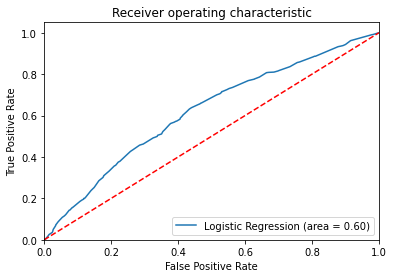

In [115]:
logit_roc_auc = roc_auc_score(Y_test, y_pred_test)
fpr, tpr, thresholds = roc_curve(Y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# Предсказываю вероятности дефолта для всего файла

In [126]:
predict_proba_all = logreg.predict_proba(data[X_list])

In [127]:
predict_all = pred_cutoff(0.25, predict_proba_all)

In [128]:
data['predict_proba'] = predict_proba_all[:, 1]
data['predict'] = predict_all

In [129]:
data.head()

,fpd5_flg,dt,gender,device_quaility_index,behavioral_index,type_of_document,age,email_domain_formatted,social_status,salary,disbursment_type,os,email_index,salary_cat,age_cat,device_cat,disbursment_type_cat,predict_proba,predict
0,0,2021-01-22,0,NaN,NaN,UMID,26,GMAIL.COM,Private Company Employee,20000.000,Bank,Android,0.000,3,1,2,2,0.272,1.000
1,0,2020-12-14,1,3.000,4.000,UMID,32,GMAIL.COM,Other,18000.000,E-wallet,Android,1.000,2,2,4,1,0.316,1.000
2,1,2021-01-26,0,0.000,3.000,SSS,41,YAHOO.COM,Private Company Employee,14000.000,Bank,Android,1.000,1,4,1,2,0.306,1.000
3,1,2020-12-10,1,0.000,5.000,TIN,28,GMAIL.COM,BPO Professionals,40000.000,E-wallet,Android,1.000,5,2,1,1,0.342,1.000
4,1,2021-01-17,0,3.000,3.000,UMID,31,GMAIL.COM,BPO Professionals,25000.000,Bank,Android,0.000,3,2,4,2,0.240,0.000


In [130]:
# сохраняю результат
data.to_excel('result.xlsx', index = False)

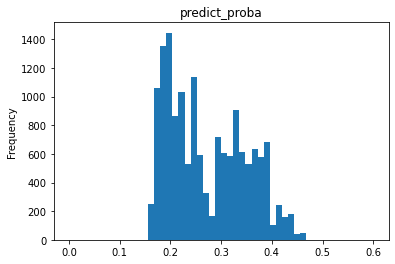

In [131]:
plt.hist(data['predict_proba'], bins = 50, range = (0, 0.6))
plt.title('predict_proba')
plt.ylabel('Frequency')
plt.show()